<a href="https://colab.research.google.com/github/Aizaanjum5/Sentiment-Analyzer-NLP/blob/main/NLP_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**University Review Sentiment Analyzer:**

This project analyzes university and course reviews and predicts whether the sentiment expressed in the text is positive, neutral, or negative. The main goal is to compare classical machine learning models with a deep learning model, specifically an LSTM network, and evaluate how well each approach performs on the same text classification task. Additionally, the project includes a simple Streamlit web application that allows real-time prediction, meaning users can type a review and instantly see the predicted sentiment from all models.


In [2]:
import pandas as pd
import numpy as np
import re
import string
import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

nltk.download("punkt")
nltk.download("stopwords")

sns.set(style="whitegrid")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
from google.colab import files

uploaded = files.upload()
df_raw = pd.read_excel("finalDataset0.2.xlsx")
df_raw.info()
df_raw.head()


Saving finalDataset0.2.xlsx to finalDataset0.2.xlsx
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   teaching             185 non-null    int64  
 1   teaching.1           185 non-null    object 
 2   coursecontent        184 non-null    float64
 3   coursecontent.1      185 non-null    object 
 4   examination          184 non-null    float64
 5   Examination          185 non-null    object 
 6   labwork              185 non-null    int64  
 7   labwork.1            185 non-null    object 
 8   library_facilities   182 non-null    float64
 9    library_facilities  185 non-null    object 
 10  extracurricular      185 non-null    int64  
 11  extracurricular.1    185 non-null    object 
dtypes: float64(3), int64(3), object(6)
memory usage: 17.5+ KB


,teaching,teaching.1,coursecontent,coursecontent.1,examination,Examination,labwork,labwork.1,library_facilities,library_facilities,extracurricular,extracurricular.1
0,0,teacher are punctual but they should also give...,0.0,content of courses are average,1.0,examination pattern is good,-1,"not satisfactory, lab work must include latest...",0.0,library facilities are good but number of book...,1,extracurricular activities are excellent and p...
1,1,Good,-1.0,Not good,1.0,Good,1,Good,-1.0,Not good,1,Good
2,1,Excellent lectures are delivered by teachers a...,1.0,All courses material provide very good knowled...,1.0,Exam pattern is up to the mark and the Cgpa de...,1,Lab work is properly covered in the labs by th...,1.0,Library facilities are excellent in terms of g...,1,Extra curricular activities also help students...
3,1,Good,-1.0,Content of course is perfectly in line with th...,-1.0,Again the university tests students of their a...,1,Good,0.0,Its the best thing i have seen in this univers...,-1,Complete wastage of time. Again this opinion i...
4,1,teachers give us all the information required ...,1.0,content of courses improves my knowledge,1.0,examination pattern is good,1,practical work provides detail knowledge of th...,1.0,library has huge collection of books from diff...,1,extracurricular activities increases mental an...


In [4]:
text_col = "teaching.1"   # text
label_col = "teaching"    # numeric -1/0/1

df = df_raw[[text_col, label_col]].dropna().copy()
df = df.rename(columns={text_col: "text", label_col: "label"})

df.head()
df["label"].value_counts()


,count
label,
1,137
0,35
-1,13


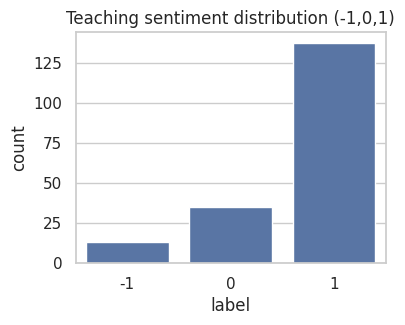

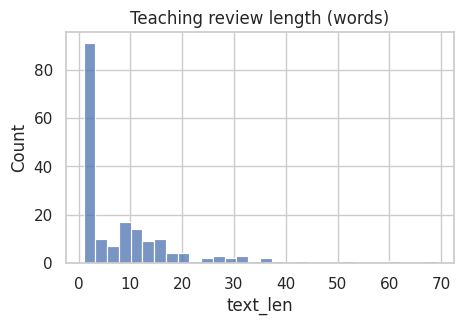

In [5]:
plt.figure(figsize=(4,3))
sns.countplot(x="label", data=df)
plt.title("Teaching sentiment distribution (-1,0,1)")
plt.show()

df["text_len"] = df["text"].astype(str).str.split().str.len()
plt.figure(figsize=(5,3))
sns.histplot(df["text_len"], bins=30)
plt.title("Teaching review length (words)")
plt.show()


In [6]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words("english"))

def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stop_words and len(w) > 1]
    return " ".join(tokens)


In [7]:
import nltk
nltk.download('punkt_tab')

def test_clean_text():
    sample = "Hello!! Visit https://google.com NOW 123"
    cleaned = clean_text(sample)
    assert "http" not in cleaned
    assert "123" not in cleaned
    assert "hello" in cleaned
    assert "visit" in cleaned
    print("✓ test_clean_text passed")

test_clean_text()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


✓ test_clean_text passed


In [8]:
df["clean_text"] = df["text"].astype(str).apply(clean_text)

X = df["clean_text"].values
y = df["label"].values

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

print("Train:", len(X_train), "Val:", len(X_valid), "Test:", len(X_test))


Train: 129 Val: 28 Test: 28


In [9]:
os.makedirs("saved_models", exist_ok=True)

# TF-IDF + Logistic Regression
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_valid_tfidf = tfidf.transform(X_valid)
X_test_tfidf  = tfidf.transform(X_test)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_tfidf, y_train)
y_pred_lr = log_reg.predict(X_test_tfidf)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


joblib.dump(tfidf, "saved_models/tfidf_vectorizer.joblib")
joblib.dump(log_reg, "saved_models/log_reg_model.joblib")


Logistic Regression Accuracy: 0.7142857142857143
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         2
           0       0.00      0.00      0.00         6
           1       0.71      1.00      0.83        20

    accuracy                           0.71        28
   macro avg       0.24      0.33      0.28        28
weighted avg       0.51      0.71      0.60        28



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


['saved_models/log_reg_model.joblib']

In [10]:
bow_vect = CountVectorizer(max_features=10000, ngram_range=(1,2))
X_train_bow = bow_vect.fit_transform(X_train)
X_valid_bow = bow_vect.transform(X_valid)
X_test_bow  = bow_vect.transform(X_test)

nb = MultinomialNB()
nb.fit(X_train_bow, y_train)
y_pred_nb = nb.predict(X_test_bow)

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

joblib.dump(bow_vect, "saved_models/bow_vectorizer.joblib")
joblib.dump(nb, "saved_models/nb_model.joblib")


Naive Bayes Accuracy: 0.75
              precision    recall  f1-score   support

          -1       1.00      0.50      0.67         2
           0       0.00      0.00      0.00         6
           1       0.74      1.00      0.85        20

    accuracy                           0.75        28
   macro avg       0.58      0.50      0.51        28
weighted avg       0.60      0.75      0.66        28



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


['saved_models/nb_model.joblib']

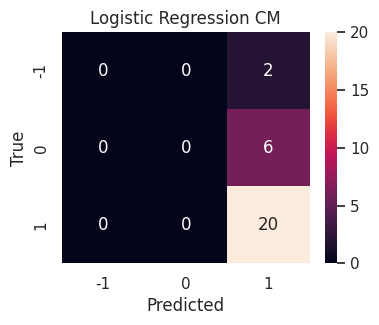

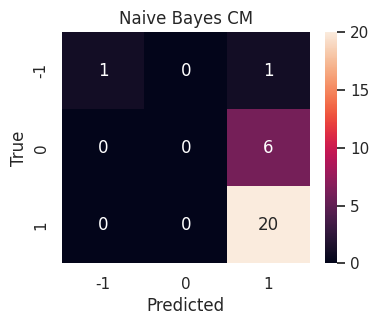

In [11]:
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=sorted(np.unique(y_true)),
                yticklabels=sorted(np.unique(y_true)))
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

plot_cm(y_test, y_pred_lr, "Logistic Regression CM")
plot_cm(y_test, y_pred_nb, "Naive Bayes CM")


In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder


In [13]:
max_words = 20000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_valid_seq = tokenizer.texts_to_sequences(X_valid)
X_test_seq  = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding="post")
X_valid_pad = pad_sequences(X_valid_seq, maxlen=max_len, padding="post")
X_test_pad  = pad_sequences(X_test_seq,  maxlen=max_len, padding="post")

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_valid_enc = le.transform(y_valid)
y_test_enc  = le.transform(y_test)

num_classes = len(le.classes_)
print("Classes:", le.classes_)


Classes: [-1  0  1]


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/6
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 269ms/step - accuracy: 0.4531 - loss: 1.0778 - val_accuracy: 0.7500 - val_loss: 0.9628
Epoch 2/6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7490 - loss: 0.9519 - val_accuracy: 0.7500 - val_loss: 0.8718
Epoch 3/6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7608 - loss: 0.8657 - val_accuracy: 0.7500 - val_loss: 0.7756
Epoch 4/6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7490 - loss: 0.7836 - val_accuracy: 0.7500 - val_loss: 0.7668
Epoch 5/6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7451 - loss: 0.8033 - val_accuracy: 0.7500 - val_loss: 0.8286
Epoch 6/6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7432 - loss: 0.8812 - val_accuracy: 0.7500 - val_loss: 0.7866
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
LSTM Accuracy: 0.7142857142857143
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         2
           0       0.00      0.00      0.00         6
           1     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


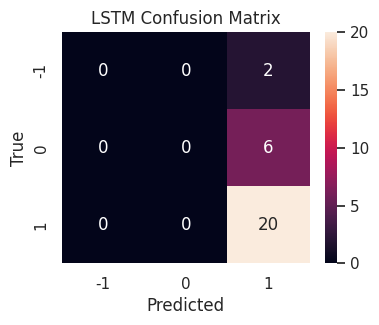

['saved_models/label_encoder.joblib']

In [14]:
embedding_dim = 64

model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

history = model.fit(
    X_train_pad, y_train_enc,
    validation_data=(X_valid_pad, y_valid_enc),
    epochs=6,
    batch_size=64,
    verbose=1
)

y_pred_proba = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_proba, axis=1)

print("LSTM Accuracy:", accuracy_score(y_test_enc, y_pred))
print(classification_report(y_test_enc, y_pred, target_names=[str(c) for c in le.classes_]))

cm = confusion_matrix(y_test_enc, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("LSTM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

model.save("saved_models/lstm_model.h5")
joblib.dump(tokenizer, "saved_models/tokenizer.joblib")
joblib.dump(le, "saved_models/label_encoder.joblib")

In [15]:
from google.colab import files

for fname in [
    "saved_models/tfidf_vectorizer.joblib",
    "saved_models/log_reg_model.joblib",
    "saved_models/bow_vectorizer.joblib",
    "saved_models/nb_model.joblib",
    "saved_models/tokenizer.joblib",
    "saved_models/label_encoder.joblib",
    "saved_models/lstm_model.h5",
]:
    files.download(fname)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Limitations

- The dataset is relatively small (around 185 reviews), so complex models such as LSTMs cannot fully learn rich patterns and may not generalize well to new data.
- The class distribution is imbalanced, with more positive reviews than negative or neutral ones, which causes the models to perform worse on minority classes.
- The current approach mainly focuses on the teaching aspect of the reviews, so other aspects (course content, examination, lab, library, extracurricular activities) are not yet modeled jointly.
- The models use basic text representations (TF–IDF, Bag-of-Words, and a simple LSTM) and do not yet include more advanced context-aware architectures such as transformer-based models (e.g., BERT).


Conclusion

This project implements a complete sentiment analysis pipeline on real university review data: from text preprocessing and feature engineering through training multiple classical (Logistic Regression, Naive Bayes) and neural (LSTM) models to deploying a Streamlit web application for interactive prediction. The experiments show that, on a small and imbalanced dataset, classical models can achieve accuracy comparable to the LSTM model while clearly separating positive and negative feedback. In the future, the system can be improved by collecting more and more balanced data, modeling all review aspects together, and experimenting with transformer-based architectures (such as BERT) to capture deeper semantic information and improve performance, especially for neutral and negative sentiments.
